<a href="https://colab.research.google.com/github/jtw1018/VDSR_ipynb/blob/master/VDSR_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VDSR Demo - Pytorch

## [ Colab 에서 실행 ]

- 깃허브 레포지터리를 clone 할 폴더 위치 지정

In [1]:
cd '/content'

/content


- 깃허브 레포지터리 clone

In [2]:
!git clone https://github.com/jtw1018/VDSR_ipynb.git

Cloning into 'VDSR_ipynb'...
remote: Enumerating objects: 154, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 154 (delta 5), reused 0 (delta 0), pack-reused 142
Receiving objects: 100% (154/154), 86.11 MiB | 16.70 MiB/s, done.
Resolving deltas: 100% (56/56), done.


- 작업 폴더로 이동

In [3]:
cd '/content/VDSR_ipynb'

/content/VDSR_ipynb


- 패키지 로드

In [4]:
# Load the package you are going to use
import torch
from torch.autograd import Variable
from PIL import Image
import numpy as np
import time, math
import matplotlib.pyplot as plt
%matplotlib inline

- 사전학습 모델 로딩

In [5]:
# Load the pretrained model
model = torch.load("model/model_epoch_50.pth")["model"]

/usr/local/lib/python3.7/dist-packages/torch/serialization.py:786: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:786: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:786: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has changed. you can retrieve the original source code by accessing the object's source attribute or set 

  - 이 모델은 데이터 증대를 통해 [291](https://drive.google.com/open?id=1Rt3asDLuMgLuJvPA1YrhyjWhb97Ly742) 개의 이미지에 대해 학습
  - 이 구현에서는 바이어스가 사용되지 않으며 그래디언트 클리핑의 구현은 논문과 다름 

In [6]:
# Load the groundtruth image and the low-resolution image (downscaled with a factor of 4)
im_gt = Image.open("Set5/butterfly_GT.bmp").convert("RGB")
im_b = Image.open("Set5/butterfly_GT_scale_4.bmp").convert("RGB")

In [7]:
# Convert the images into YCbCr mode and extraction the Y channel (for PSNR calculation)
im_gt_ycbcr = np.array(im_gt.convert("YCbCr"))
im_b_ycbcr = np.array(im_b.convert("YCbCr"))
im_gt_y = im_gt_ycbcr[:,:,0].astype(float)
im_b_y = im_b_ycbcr[:,:,0].astype(float)

In [8]:
# Here is the function for PSNR calculation
def PSNR(pred, gt, shave_border=0):
    height, width = pred.shape[:2]
    pred = pred[shave_border:height - shave_border, shave_border:width - shave_border]
    gt = gt[shave_border:height - shave_border, shave_border:width - shave_border]
    imdff = pred - gt
    rmse = math.sqrt(np.mean(imdff ** 2))
    if rmse == 0:
        return 100
    return 20 * math.log10(255.0 / rmse)

In [9]:
# Calculate the PNSR for bicubic interpolation
# For best PSNR score, you will have to use Matlab for color space transformation, 
# since it is different from Python's implementation
psnr_bicubic = round(PSNR(im_gt_y, im_b_y), 3)
print('PSNR for bicubic is {}dB'.format(psnr_bicubic))

PSNR for bicubic is 20.825dB


In [10]:
# Prepare for the input, a pytorch tensor
im_input = im_b_y/255.
im_input = Variable(torch.from_numpy(im_input).float()).\
    view(1, -1, im_input.shape[0], im_input.shape[1])

In [11]:
# Let's try the network feedforward in cpu mode
model = model.cpu()

In [12]:
# Let's see how long does it take for processing
start_time = time.time()
out = model(im_input)
elapsed_time = round((time.time() - start_time), 3)
print("It takes {}s for processing in cpu mode".format(elapsed_time))

It takes 1.663s for processing in cpu mode


In [13]:
# Now let's try the network feedforward in gpu mode
model = model.cuda()
im_input = im_input.cuda()

In [14]:
# Let's see how long does it take for processing in gpu mode
start_time = time.time()
out = model(im_input)
elapsed_time = round((time.time() - start_time), 3)
print("It takes {}s for processing in gpu mode".format(elapsed_time))

It takes 6.013s for processing in gpu mode


In [15]:
# Get the output image
out = out.cpu()
im_h_y = out.data[0].numpy().astype(np.float32)
im_h_y = im_h_y * 255.
im_h_y[im_h_y < 0] = 0
im_h_y[im_h_y > 255.] = 255.
im_h_y = im_h_y[0,:,:]

In [16]:
# Calculate the PNSR for vdsr prediction
psnr_predicted = round(PSNR(im_gt_y, im_h_y), 3)
print('PSNR for vdsr is {}dB'.format(psnr_predicted))

PSNR for vdsr is 25.429dB


In [17]:
# Calculate the PNSR different between bicubic interpolation and vdsr prediction
print("PSNR improvement is {}dB".format(round((psnr_predicted - psnr_bicubic), 3)))

PSNR improvement is 4.604dB


In [18]:
# Define the colorization function
# We'll reuse the Cb and Cr channels from bicubic interpolation
def colorize(y, ycbcr): 
    img = np.zeros((y.shape[0], y.shape[1], 3), np.uint8)
    img[:,:,0] = y
    img[:,:,1] = ycbcr[:,:,1]
    img[:,:,2] = ycbcr[:,:,2]
    img = Image.fromarray(img, "YCbCr").convert("RGB")
    return img

In [19]:
# Colorize the grey-level image and convert into RGB mode
im_h = colorize(im_h_y, im_b_ycbcr)
im_gt = Image.fromarray(im_gt_ycbcr, "YCbCr").convert("RGB")
im_b = Image.fromarray(im_b_ycbcr, "YCbCr").convert("RGB")

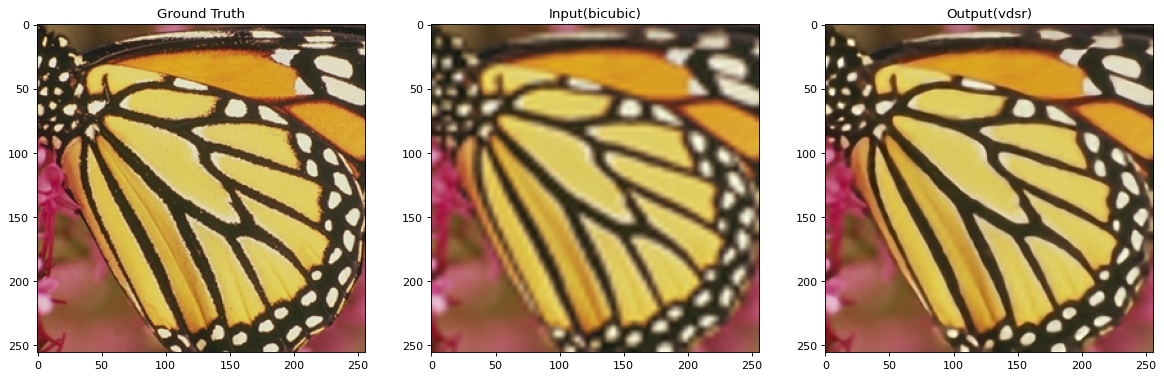

In [22]:
# Result visualization
fig = plt.figure(figsize=(18, 16), dpi= 80)
ax = plt.subplot("131")
ax.imshow(im_gt)
ax.set_title("Ground Truth")

ax = plt.subplot("132")
ax.imshow(im_b)
ax.set_title("Input(bicubic)")

ax = plt.subplot("133")
ax.imshow(im_h)
ax.set_title("Output(vdsr)")
plt.show()